# **Laboratorul 13 PMP**

In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv("date.csv", sep=None, engine="python")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

df_num = df.select_dtypes(include=[np.number])

print("Numeric columns:", df_num.columns.tolist())
display(df_num.head())

if df_num.shape[1] < 2:
    raise ValueError("Nu găsesc 2 coloane numerice în date.csv. Verifică separatorul / conținutul fișierului.")

x_1 = df_num.iloc[:, 0].to_numpy()
y_1 = df_num.iloc[:, 1].to_numpy()

print("Loaded x,y:", x_1.shape, y_1.shape)


Shape: (32, 2)
Columns: ['-1.081', '9.357']


,-1.081,9.357
0,-0.888,8.322
1,-0.623,8.745
2,-0.480,7.346
3,-0.505,7.028
4,-0.345,4.032


Numeric columns: ['-1.081', '9.357']


,-1.081,9.357
0,-0.888,8.322
1,-0.623,8.745
2,-0.480,7.346
3,-0.505,7.028
4,-0.345,4.032


Loaded x,y: (32,) (32,)


In [9]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

az.style.use("arviz-darkgrid")

def make_standardized_poly(x, y, order):
    x_p = np.vstack([x**i for i in range(1, order+1)])
    x_s = (x_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)
    y_s = (y - y.mean()) / y.std()
    return x_s, y_s

def fit_poly_model(x_s, y_s, order, beta_sigma):
    with pm.Model() as model:
        alpha = pm.Normal("alpha", mu=0, sigma=1)
        beta  = pm.Normal("beta", mu=0, sigma=beta_sigma, shape=order)
        eps   = pm.HalfNormal("eps", sigma=5)

        mu = alpha + pm.math.dot(beta, x_s)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=eps, observed=y_s)

        idata = pm.sample(
            draws=2000,
            tune=2000,
            target_accept=0.9,
            random_seed=42,
            return_inferencedata=True
        )
    return model, idata


## **1.1.a**

Output()

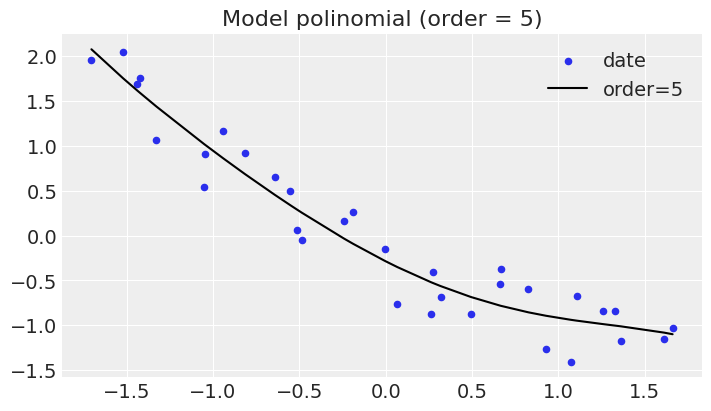

In [10]:
order = 5

x_s, y_s = make_standardized_poly(x_1, y_1, order)
model_o, idata_o = fit_poly_model(x_s, y_s, order, beta_sigma=10)

alpha_mean = idata_o.posterior["alpha"].mean(("chain","draw")).values
beta_mean  = idata_o.posterior["beta"].mean(("chain","draw")).values

y_post = alpha_mean + np.dot(beta_mean, x_s)

idx = np.argsort(x_s[0])
plt.figure(figsize=(7,4))
plt.scatter(x_s[0], y_s, s=20, label="date")
plt.plot(x_s[0][idx], y_post[idx], color="black", label=f"order={order}")
plt.legend()
plt.title("Model polinomial (order = 5)")
plt.show()


## **1.1.b**

Output()

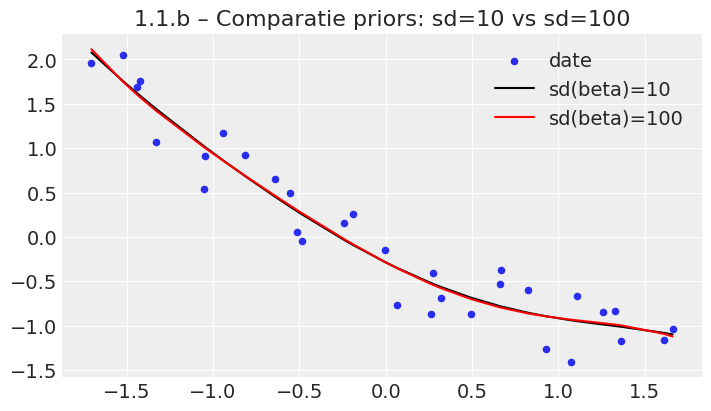

In [11]:
model_100, idata_100 = fit_poly_model(x_s, y_s, order, beta_sigma=100)

alpha_100 = idata_100.posterior["alpha"].mean(("chain","draw")).values
beta_100  = idata_100.posterior["beta"].mean(("chain","draw")).values
y_100 = alpha_100 + np.dot(beta_100, x_s)

plt.figure(figsize=(7,4))
plt.scatter(x_s[0], y_s, s=20, label="date")
plt.plot(x_s[0][idx], y_post[idx], color="black", label="sd(beta)=10")
plt.plot(x_s[0][idx], y_100[idx], color="red", label="sd(beta)=100")
plt.title("1.1.b – Comparatie priors: sd=10 vs sd=100")
plt.legend()
plt.show()


## **1.1.b prior vectorial (order=5)**

Output()

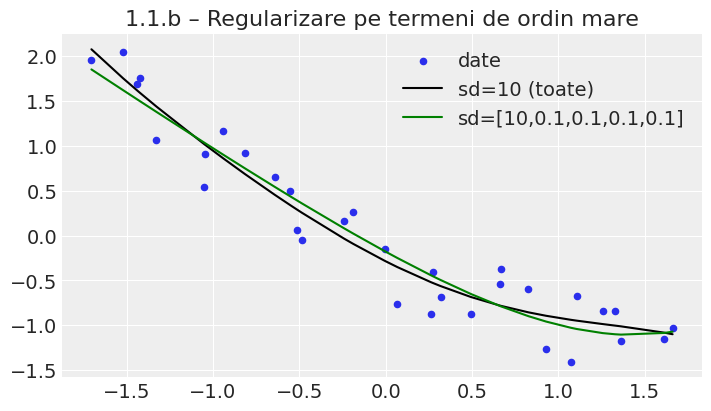

In [12]:
assert order == 5

with pm.Model() as model_vec:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta  = pm.Normal(
        "beta",
        mu=0,
        sigma=np.array([10, 0.1, 0.1, 0.1, 0.1]),
        shape=5
    )
    eps = pm.HalfNormal("eps", sigma=5)

    mu = alpha + pm.math.dot(beta, x_s)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=eps, observed=y_s)

    idata_vec = pm.sample(
        draws=2000, tune=2000, target_accept=0.9,
        random_seed=42, return_inferencedata=True
    )

alpha_vec = idata_vec.posterior["alpha"].mean(("chain","draw")).values
beta_vec  = idata_vec.posterior["beta"].mean(("chain","draw")).values
y_vec = alpha_vec + np.dot(beta_vec, x_s)

plt.figure(figsize=(7,4))
plt.scatter(x_s[0], y_s, s=20, label="date")
plt.plot(x_s[0][idx], y_post[idx], color="black", label="sd=10 (toate)")
plt.plot(x_s[0][idx], y_vec[idx], color="green", label="sd=[10,0.1,0.1,0.1,0.1]")
plt.title("1.1.b – Regularizare pe termeni de ordin mare")
plt.legend()
plt.show()


## **1.2**

Output()

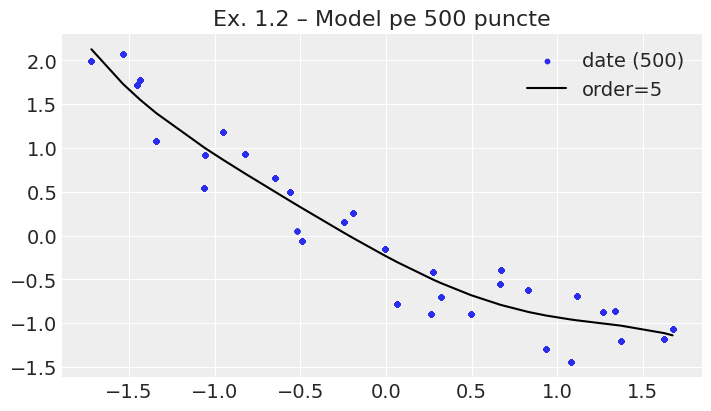

In [13]:
rng = np.random.default_rng(42)
idx500 = rng.choice(len(x_1), size=500, replace=True)

x_500 = x_1[idx500]
y_500 = y_1[idx500]

x_s500, y_s500 = make_standardized_poly(x_500, y_500, order)

model_500, idata_500 = fit_poly_model(x_s500, y_s500, order, beta_sigma=10)

alpha_500 = idata_500.posterior["alpha"].mean(("chain","draw")).values
beta_500  = idata_500.posterior["beta"].mean(("chain","draw")).values
y_500_post = alpha_500 + np.dot(beta_500, x_s500)

idxs = np.argsort(x_s500[0])
plt.figure(figsize=(7,4))
plt.scatter(x_s500[0], y_s500, s=10, label="date (500)")
plt.plot(x_s500[0][idxs], y_500_post[idxs], color="black", label=f"order={order}")
plt.title("Ex. 1.2 – Model pe 500 puncte")
plt.legend()
plt.show()


## **1.3**

Output()

Output()

Output()

Output()

Output()

Output()

=== WAIC compare (deviance) — mai mic = mai bun ===


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
quadratic,0,13.242789,2.712749,0.000000,1.0,4.546640,0.000000,False,deviance
cubic,1,15.016025,3.378600,1.773236,0.0,4.459753,0.355001,False,deviance
linear,2,31.046784,2.498591,17.803995,0.0,5.353695,5.551907,False,deviance


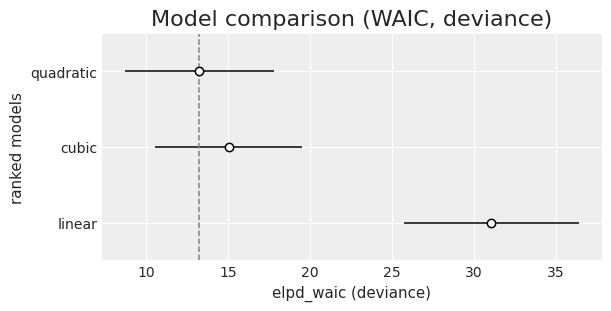

=== LOO compare (deviance) — mai mic = mai bun ===


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
quadratic,0,13.328748,2.755729,0.000000,1.000000e+00,4.557540,0.000000,False,deviance
cubic,1,15.183950,3.462563,1.855202,0.000000e+00,4.472047,0.377070,False,deviance
linear,2,31.117967,2.534183,17.789219,1.028067e-13,5.370298,5.564925,False,deviance


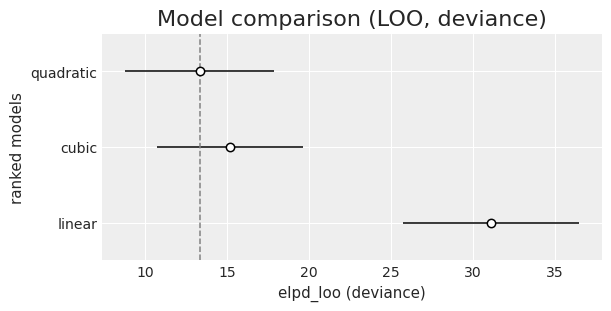

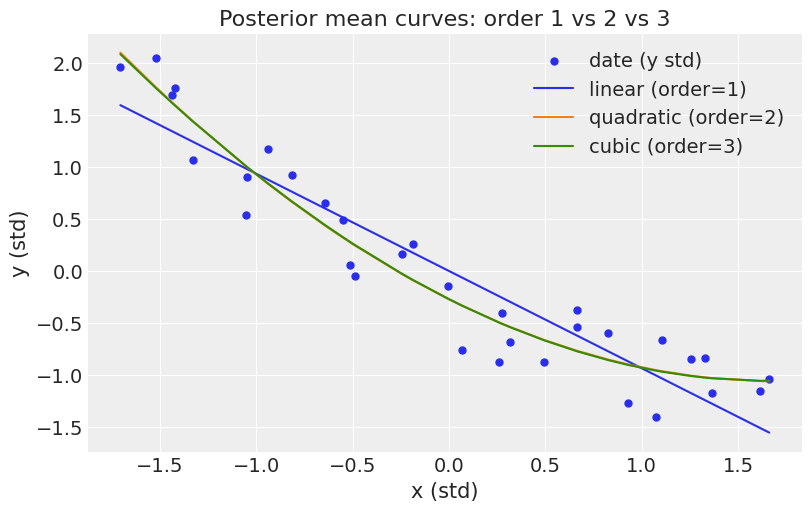

Best model by WAIC: quadratic
Best model by LOO : quadratic


In [16]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

def fit_order(order, beta_sigma=10):
    x_s, y_s = make_standardized_poly(x_1, y_1, order)
    model, idata = fit_poly_model(x_s, y_s, order, beta_sigma=beta_sigma)
    pm.compute_log_likelihood(idata, model=model)
    return x_s, y_s, model, idata

x1_s, y_s, m1, idata1 = fit_order(1, beta_sigma=10)
x2_s, _,   m2, idata2 = fit_order(2, beta_sigma=10)
x3_s, _,   m3, idata3 = fit_order(3, beta_sigma=10)

idatas = {"linear": idata1, "quadratic": idata2, "cubic": idata3}

cmp_waic = az.compare(idatas, ic="waic", scale="deviance")
print("=== WAIC compare (deviance) — mai mic = mai bun ===")
display(cmp_waic)
az.plot_compare(cmp_waic)
plt.title("Model comparison (WAIC, deviance)")
plt.show()

cmp_loo = az.compare(idatas, ic="loo", scale="deviance")
print("=== LOO compare (deviance) — mai mic = mai bun ===")
display(cmp_loo)
az.plot_compare(cmp_loo)
plt.title("Model comparison (LOO, deviance)")
plt.show()

def posterior_mean_curve(idata, x_s):
    alpha_mean = idata.posterior["alpha"].mean(("chain","draw")).values
    beta_mean  = idata.posterior["beta"].mean(("chain","draw")).values
    return alpha_mean + np.dot(beta_mean, x_s)

yhat1 = posterior_mean_curve(idata1, x1_s)
yhat2 = posterior_mean_curve(idata2, x2_s)
yhat3 = posterior_mean_curve(idata3, x3_s)

x_plot = x1_s[0]
idx = np.argsort(x_plot)

plt.figure(figsize=(8,5))
plt.scatter(x_plot, y_s, s=25, label="date (y std)")
plt.plot(x_plot[idx], yhat1[idx], label="linear (order=1)")
plt.plot(x_plot[idx], yhat2[idx], label="quadratic (order=2)")
plt.plot(x_plot[idx], yhat3[idx], label="cubic (order=3)")
plt.title("Posterior mean curves: order 1 vs 2 vs 3")
plt.xlabel("x (std)")
plt.ylabel("y (std)")
plt.legend()
plt.show()

best_waic = cmp_waic.index[0]
best_loo  = cmp_loo.index[0]
print("Best model by WAIC:", best_waic)
print("Best model by LOO :", best_loo)
